Epoch 0, Loss: 0.4803953170776367
Epoch 50, Loss: 0.22264930605888367
Epoch 100, Loss: 0.009190035983920097
Epoch 150, Loss: 0.00014126193127594888
Epoch 200, Loss: 3.4558156585262623e-06
Epoch 250, Loss: 8.323529954168407e-08
Epoch 300, Loss: 1.3005366783502836e-09
Epoch 350, Loss: 3.1904923147862974e-10
Epoch 400, Loss: 1.8754547914667796e-10
Epoch 450, Loss: 3.7639347194584616e-10


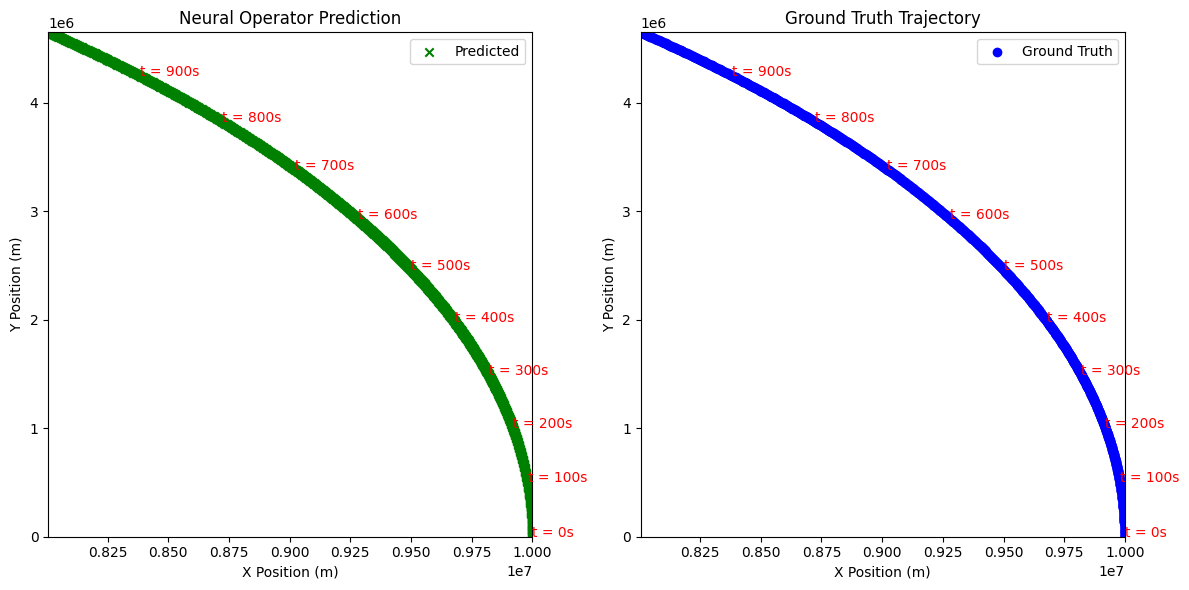

Initial Ground Truth Position: [10000000.        0.]
Initial Predicted Position: [ 1.0000001e+07 -2.9802322e-01]


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
epsilon = 1e-6   # To prevent division by zero

# Perturbed two-body function with mass loss
def two_body_perturbed(t, state, mdot):
    r, v, m = state[:2], state[2:4], state[4]
    r_norm = max(np.linalg.norm(r), epsilon)
    a = -G * m / (r_norm ** 3) * r
    dm_dt = mdot
    return [v[0], v[1], a[0], a[1], dm_dt]

# Numerical integrator
def generate_trajectory(r0, v0, m0, mdot, T=1000, dt=1):
    t_span = (0, T)
    state0 = np.hstack((r0, v0, m0))
    sol = solve_ivp(two_body_perturbed, t_span, state0, args=(mdot,), t_eval=np.arange(0, T, dt))
    return sol.t, sol.y[:2].T  # (T, 2) position matrix

# Initial conditions
r0 = np.array([1.0e7, 0.0])
v0 = np.array([0.0, 5000.0])
m0 = 5.972e24
mdot = -1.0e16
T = 1000
dt = 1
t, ground_truth = generate_trajectory(r0, v0, m0, mdot, T, dt)

# Convert to tensors
initial_conditions = torch.tensor([r0[0], r0[1], v0[0], v0[1], m0, mdot], dtype=torch.float32).unsqueeze(0)
ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.float32)

# Normalize using separate factors
input_norm_factor = torch.max(torch.abs(initial_conditions))
output_norm_factor = torch.max(torch.abs(ground_truth_tensor))

initial_conditions_norm = initial_conditions / input_norm_factor
ground_truth_tensor_norm = ground_truth_tensor / output_norm_factor

# Define the model
class FourierNeuralOperator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Model, optimizer, loss
model = FourierNeuralOperator(input_dim=6, output_dim=2000)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(initial_conditions_norm)
    loss = criterion(pred, ground_truth_tensor_norm.reshape(1, -1))
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predict and unnormalize
predicted_norm = model(initial_conditions_norm).detach().numpy().reshape(-1, 2)
predicted_trajectory = predicted_norm * output_norm_factor.numpy()
ground_truth = ground_truth_tensor.numpy()  # Already in original scale

# Plotting
def safe_min(arr): return np.nanmin(arr[np.isfinite(arr)]) if np.any(np.isfinite(arr)) else 0
def safe_max(arr): return np.nanmax(arr[np.isfinite(arr)]) if np.any(np.isfinite(arr)) else 1

def plot_trajectories(t, predicted, ground_truth):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    x_min = safe_min(np.concatenate([predicted[:, 0], ground_truth[:, 0]]))
    x_max = safe_max(np.concatenate([predicted[:, 0], ground_truth[:, 0]]))
    y_min = safe_min(np.concatenate([predicted[:, 1], ground_truth[:, 1]]))
    y_max = safe_max(np.concatenate([predicted[:, 1], ground_truth[:, 1]]))

    axes[0].scatter(predicted[:, 0], predicted[:, 1], color='green', label="Predicted", marker='x')
    for i in range(0, len(t), len(t)//10):
        axes[0].annotate(f"t = {int(t[i])}s", (predicted[i, 0], predicted[i, 1]), fontsize=10, color="red")
    axes[0].set_title("Neural Operator Prediction")
    axes[0].set_xlabel("X Position (m)")
    axes[0].set_ylabel("Y Position (m)")
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[0].legend()

    axes[1].scatter(ground_truth[:, 0], ground_truth[:, 1], color='blue', label="Ground Truth", marker='o')
    for i in range(0, len(t), len(t)//10):
        axes[1].annotate(f"t = {int(t[i])}s", (ground_truth[i, 0], ground_truth[i, 1]), fontsize=10, color="red")
    axes[1].set_title("Ground Truth Trajectory")
    axes[1].set_xlabel("X Position (m)")
    axes[1].set_ylabel("Y Position (m)")
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(y_min, y_max)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_trajectories(t, predicted_trajectory, ground_truth)

# Optional: Verify first point match
print("Initial Ground Truth Position:", ground_truth[0])
print("Initial Predicted Position:", predicted_trajectory[0])
